In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
df = pd.read_csv('data/review-raw.csv')
df.head()

,Unnamed: 0,recommendationid,author_id,review,timestamp,voted_up,weighted_vote_score,app_id
0,0,186781078,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,0.652997,10
1,1,184974430,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,0.581749,10
2,2,186584044,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,0.628378,10
3,3,186564689,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,0.000000,10
4,4,186418367,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,0.000000,10


In [3]:
df.drop(columns=['Unnamed: 0', 'recommendationid', 'weighted_vote_score'], inplace=True)
df.head()

,author_id,review,timestamp,voted_up,app_id
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10


### Rename columns

In [4]:
column_names = {
    'author_id': 'user_id',
    'app_id': 'item_id',
    'voted_up': 'rating',
    'timestamp': 'timestamp',
    'review': 'review'
}
df.rename(columns=column_names, inplace=True)
df.head()

,user_id,review,timestamp,rating,item_id
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10


### Create user/item indices

In [5]:
user_map = {u: i for i, u in enumerate(df['user_id'].unique())}
item_map = {i: j for j, i in enumerate(df['item_id'].unique())}

df['user_idx'] = np.array([user_map[u] for u in df['user_id']])
df['item_idx'] = np.array([item_map[i] for i in df['item_id']])
df.head()

,user_id,review,timestamp,rating,item_id,user_idx,item_idx
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10,0,0
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10,1,0
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10,2,0
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10,3,0
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10,4,0


### Create implicit and explicit rating

In [6]:
df['rating_exp'] = df['rating'].apply(lambda x: 1 if x else -1)
df['rating_imp'] = df['rating'].astype(int)
df.head()

,user_id,review,timestamp,rating,item_id,user_idx,item_idx,rating_exp,rating_imp
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10,0,0,1,1
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10,1,0,1,1
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10,2,0,1,1
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10,3,0,1,1
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10,4,0,1,1


### Feature engineering timestamp

In [7]:
df['timestamp'].describe()

count    1.766443e+06
mean     1.703476e+09
std      7.612711e+07
min      1.287267e+09
25%      1.732522e+09
50%      1.736571e+09
75%      1.737630e+09
max      1.738732e+09
Name: timestamp, dtype: float64

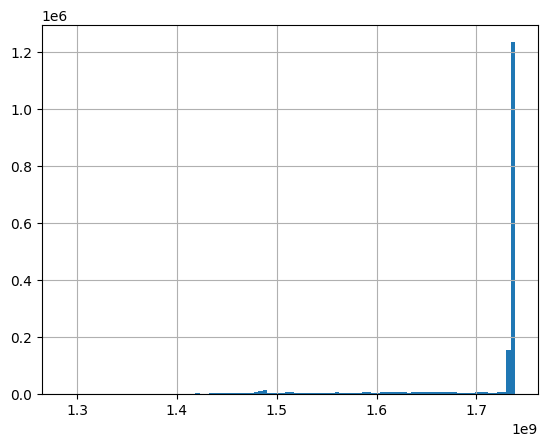

In [8]:
df['timestamp'].hist(bins=100)
plt.show()

#### Min-max Normalization

In [9]:
def normalize_timestamps(timestamps):
    min_time = timestamps.min()
    max_time = timestamps.max()
    normalized = (timestamps - min_time) / (max_time - min_time)
    return normalized

df['mm_timestamp'] = normalize_timestamps(df['timestamp'])
df['mm_timestamp'].head()

0    0.998997
1    0.994407
2    0.998472
3    0.998414
4    0.998056
Name: mm_timestamp, dtype: float64

#### Z-score Standardization

In [10]:
def standardize_timestamps(timestamps):
    mean_time = timestamps.mean()
    std_time = timestamps.std()
    standardized = (timestamps - mean_time) / std_time
    return standardized

df['z_timestamp'] = standardize_timestamps(df['timestamp'])
df['z_timestamp'].head()

0    0.457172
1    0.429949
2    0.454056
3    0.453711
4    0.451588
Name: z_timestamp, dtype: float64

#### Log Transformation

In [11]:
def log_normalize_timestamps(timestamps):
    min_time = timestamps.min()
    offset_timestamps = timestamps - min_time
    epsilon = 1e-10
    return np.log(offset_timestamps + epsilon)

df['log_timestamp'] = log_normalize_timestamps(df['timestamp'])
df['log_timestamp'].head()

0    19.927005
1    19.922399
2    19.926479
3    19.926420
4    19.926062
Name: log_timestamp, dtype: float64

#### Relative time encoding

In [12]:
class ReferenceTime(Enum):
    MOST_RECENT = 'most_recent'
    CURRENT = 'current'
    LAST_INTERACTION = 'last_interaction'
    
class DecayFunction(Enum):
    LINEAR = 'linear'
    EXPONENTIAL = 'exponential'
    POWER_LAW = 'power-law'
    LOG = 'log'

def relative_time_encoding(df: pd.DataFrame, reference_time: ReferenceTime = ReferenceTime.MOST_RECENT, decay_fn: DecayFunction = DecayFunction.LOG, decay_rate: float = 1.0, decay_power: float = 2.0) -> np.ndarray:
    
    """Normalize based on recency relative to a reference time"""
    if reference_time == ReferenceTime.MOST_RECENT:
        reference_time = df['timestamp'].max()  # Most recent timestamp
        df['time_diff'] = df['timestamp'].apply(lambda x: reference_time - x)
        
    elif reference_time == ReferenceTime.CURRENT:
        reference_time = pd.Timestamp.now().timestamp()
        df['time_diff'] = df['timestamp'].apply(lambda x: reference_time - x)
        
    elif reference_time == ReferenceTime.LAST_INTERACTION:
        user_last_timestamps = df.groupby('user_id')['timestamp'].max()
        df['last_timestamp'] = df['user_id'].map(user_last_timestamps)
        df['time_diff'] = df['last_timestamp'] - df['timestamp']
        df['time_diff'] = df['time_diff'].clip(lower=0)
        
    if decay_fn == DecayFunction.LINEAR:
        normalized = 1 / (1 + decay_rate * df['time_diff'])
    elif decay_fn == DecayFunction.EXPONENTIAL:
        normalized = np.exp(-decay_rate * df['time_diff'])
    elif decay_fn == DecayFunction.POWER_LAW:
        normalized = 1 / (1 + df['time_diff'] ** decay_power)
    elif decay_fn == DecayFunction.LOG:
        normalized = 1 / (1 + decay_rate * np.log(1 + df['time_diff']))
        
    return normalized.values

df['relative_most_recent_timestamp'] = relative_time_encoding(df)
df['relative_current_timestamp'] = relative_time_encoding(df, ReferenceTime.CURRENT)
df['relative_last_interaction_timestamp'] = relative_time_encoding(df, ReferenceTime.LAST_INTERACTION)
df.drop(columns=['time_diff', 'last_timestamp'], inplace=True)
df.head()

,user_id,review,timestamp,rating,item_id,user_idx,item_idx,rating_exp,rating_imp,mm_timestamp,z_timestamp,log_timestamp,relative_most_recent_timestamp,relative_current_timestamp,relative_last_interaction_timestamp
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10,0,0,1,1,0.998997,0.457172,19.927005,0.071311,0.062177,0.082497
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10,1,0,1,1,0.994407,0.429949,19.922399,0.063525,0.060450,1.000000
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10,2,0,1,1,0.998472,0.454056,19.926479,0.069231,0.061928,1.000000
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10,3,0,1,1,0.998414,0.453711,19.926420,0.069053,0.061902,1.000000
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10,4,0,1,1,0.998056,0.451588,19.926062,0.068096,0.061743,1.000000


#### Encoding Cyclical Patterns with Sine/Cosine Transformations

In [13]:
def encode_cyclical_feature(values, period):
    """
    Encode a cyclical feature using sine and cosine transformations
    
    Args:
        values: Array of values to encode (e.g., hours, weekdays)
        period: The period of the feature (24 for hours, 7 for weekdays)
    
    Returns:
        Two arrays representing the sine and cosine components
    """
    # Scale the values to [0, 2π]
    values_scaled = 2 * np.pi * values / period
    
    # Return the sine and cosine components
    return np.sin(values_scaled), np.cos(values_scaled)

def extract_cyclical_time_features(timestamps):
    """
    Extract cyclical time features from unix timestamps
    
    Args:
        timestamps: Array of unix timestamps
        
    Returns:
        DataFrame with cyclical time features
    """
    # Convert to datetime
    dates = pd.to_datetime(timestamps, unit='s')
    
    # Extract time components
    hours = dates.map(lambda x: x.hour)  # 0-23
    days_of_week = dates.map(lambda x: x.day_of_week)  # 0-6 where 0 is Monday
    days_of_month = dates.map(lambda x: x.day - 1)  # 0-30
    months = dates.map(lambda x: x.month - 1)  # 0-11
    
    # Encode cyclical features
    hour_sin, hour_cos = encode_cyclical_feature(hours, 24)
    weekday_sin, weekday_cos = encode_cyclical_feature(days_of_week, 7)
    days_of_month_sin, days_of_month_cos = encode_cyclical_feature(months, 30)
    month_sin, month_cos = encode_cyclical_feature(months, 12)
    
    # Combine into a DataFrame
    features = pd.DataFrame({
        'hour_sin': hour_sin,
        'hour_cos': hour_cos,
        'weekday_sin': weekday_sin,
        'weekday_cos': weekday_cos,
        'day_of_month_sin': days_of_month_sin,
        'day_of_month_cos': days_of_month_cos,
        'month_sin': month_sin,
        'month_cos': month_cos
    })
    
    return features

time_features = extract_cyclical_time_features(df['timestamp'])
df[time_features.columns] = time_features
df.head()

,user_id,review,timestamp,rating,item_id,user_idx,item_idx,rating_exp,rating_imp,mm_timestamp,...,relative_current_timestamp,relative_last_interaction_timestamp,hour_sin,hour_cos,weekday_sin,weekday_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos
0,76561197960432447,A legendary tactical shooter that shaped the g...,1738278781,True,10,0,0,1,1,0.998997,...,0.062177,0.082497,-0.258819,0.965926,0.433884,-0.900969,0.0,1.0,0.0,1.0
1,76561198071230926,"The best CS sure, but server browser is the il...",1736206418,True,10,1,0,1,1,0.994407,...,0.060450,1.000000,-0.258819,0.965926,0.000000,1.000000,0.0,1.0,0.0,1.0
2,76561198206216352,Some of the best memories of my childhood were...,1738041574,True,10,2,0,1,1,0.998472,...,0.061928,1.000000,0.965926,0.258819,0.781831,0.623490,0.0,1.0,0.0,1.0
3,76561198110801124,This game feels so much better than CS2. I kno...,1738015332,True,10,3,0,1,1,0.998414,...,0.061902,1.000000,-0.500000,0.866025,0.000000,1.000000,0.0,1.0,0.0,1.0
4,76561199813732773,its very fun to play you can make friends out ...,1737853720,True,10,4,0,1,1,0.998056,...,0.061743,1.000000,0.258819,0.965926,-0.781831,0.623490,0.0,1.0,0.0,1.0


### Save file

In [14]:
df.to_csv('data/review-clean.csv', index=False)